In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
import pickle

from ema_workbench.util import utilities
from ema_workbench.analysis import prim, cart

D:\EPA\Advanced_simulation\EPA1361_Model-based_Decision-making\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Open Exploration

- No policy (everything 0)
- Latin hypercube of scenarios (10.000 scenarios)
- Result: choose 20 to 50 scenarios

First, the model is initialized, using problem formulation 5.

In [3]:
# initiate model
dike_model, planning_steps = get_model_for_problem_formulation(5)

Then, a reference policy is initialized, in which all policy variables are set to 0.

In [4]:
# set reference policy as all 0's
reference = Policy("0_policy", **{l.name: 0 for l in dike_model.levers})

if we decide to include the timestep:this saves the seperate timesteps to a csv.

In [5]:
# n_scenarios = 10000
#
# # running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
# with MultiprocessingEvaluator(dike_model, n_processes=-1) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios, policies=reference, uncertainty_sampling=Samplers.LHS)
#
# utilities.save_results(results,r'generated_datasets\50ScenariosBaseCase_separate.csv')

In [6]:
# test = pd.read_csv(r'generated_datasets\50ScenariosBaseCase_separate.csv', compression='gzip',on_bad_lines='skip').dropna()
# test

However, this is the one that we will be using: combining the timesteps into a single value. The model is run, and results are saved

In [7]:
n_scenarios = 10_000

# running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=reference, uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [16:28<00:00, 10.11it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
# as we do not plan on using the timeseries data, we add them up into a single value. This is then saved to a pickle file for later use

df = pd.DataFrame()
for k in outcomes:
    test_list = []
    for i in range(len(experiments)):
        t = outcomes[k][i].sum()
        test_list.append(t)
    df[k]=test_list

with open(r'generated_datasets\open_exploration_base_policy.pkl','wb') as pickle_file:
    pickle.dump(df, pickle_file)

The data is then loaded into a dataframe. The cost of death variables are calculated and added to the data.

In [9]:
outcomes = pd.read_pickle(r'generated_datasets\open_exploration_base_policy.pkl')

In [10]:
# calculate the cost of death so every column has the same unit (€)
outcomes["A.1_Deaths_Cost"]=outcomes["A.1_Expected Number of Deaths"]*2_700_000
outcomes["A.2_Deaths_Cost"]=outcomes["A.2_Expected Number of Deaths"]*2_700_000
outcomes["A.3_Deaths_Cost"]=outcomes["A.3_Expected Number of Deaths"]*2_700_000
outcomes["A.4_Deaths_Cost"]=outcomes["A.4_Expected Number of Deaths"]*2_700_000
outcomes["A.5_Deaths_Cost"]=outcomes["A.5_Expected Number of Deaths"]*2_700_000

to_drop = ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]

outcomes.drop(to_drop, axis=1, inplace=True)
outcomes['total_cost[€]']= outcomes.sum(axis=1)

In [11]:
#input variables and output combined into a single dataframe
results = experiments.join(outcomes)
results.drop(columns=['policy','model','scenario'], inplace=True)

In [12]:
with open(r'generated_datasets\open_exploration_base_policy_ALL_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results, pickle_file)


In [13]:
results = pd.read_pickle('generated_datasets\open_exploration_base_policy_ALL_scenarios.pkl')

In [14]:
total_values = pd.DataFrame()
total_values['Expected Annual Damage'] = results['A.1_Expected Annual Damage'] + \
                                         results['A.2_Expected Annual Damage'] + \
                                         results['A.3_Expected Annual Damage'] + \
                                         results['A.4_Expected Annual Damage'] + \
                                         results['A.5_Expected Annual Damage']

total_values['Dike Investment Costs'] = results['A.1_Dike Investment Costs'] + \
                                        results['A.2_Dike Investment Costs'] + \
                                        results['A.3_Dike Investment Costs'] + \
                                        results['A.4_Dike Investment Costs'] + \
                                        results['A.5_Dike Investment Costs']

total_values['Deaths_Cost'] = results['A.1_Deaths_Cost'] + \
                              results['A.2_Deaths_Cost'] + \
                              results['A.3_Deaths_Cost'] + \
                              results['A.4_Deaths_Cost'] + \
                              results['A.5_Deaths_Cost']

# Visualizations / conclusions?

Finding the worst case scenarios top 20, difined by highest total costs

In [15]:
n_scenarios_of_interest = 20

results_of_interest = results.sort_values(by='total_cost[€]', ascending=False).head(n_scenarios_of_interest)

with open(r'generated_datasets\open_exploration_base_policy_worst_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

### Scenario Discovery
- Boxplots
- PRIM
- Scatterplots
- CART-tree

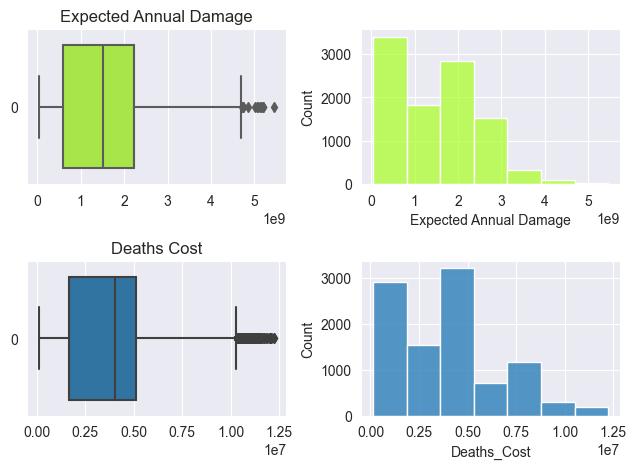

In [16]:
fig, axes = plt.subplots(2,2)

# Expected Annual Damage boxplot
sns.boxplot(
    ax=axes[0,0],
    data=total_values['Expected Annual Damage'],
    orient='h',
    color='greenyellow',
).set(title='Expected Annual Damage')

# Deaths_Cost boxplot
sns.boxplot(
    ax=axes[1,0],
    data=total_values['Deaths_Cost'],
    orient='h',
).set(title='Deaths Cost')

# Expected Annual Damage histogram
sns.histplot(
    ax=axes[0,1],
    data=total_values['Expected Annual Damage'],
    bins=7,
    color='greenyellow',
)

# Deaths_Cost histogram
sns.histplot(
    ax=axes[1,1],
    data=total_values['Deaths_Cost'],
    bins=7,
)

plt.tight_layout()

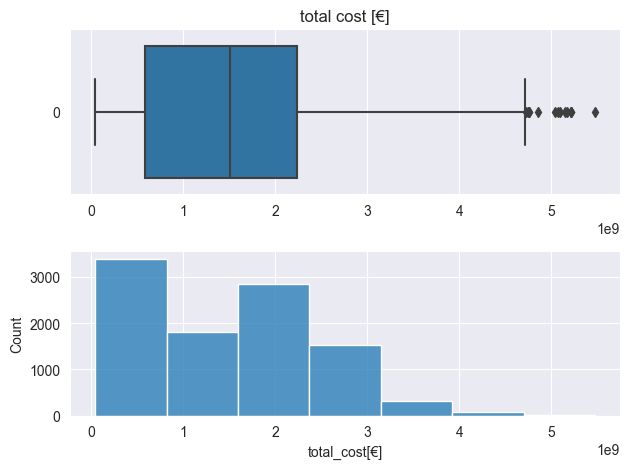

In [17]:
fig, axes = plt.subplots(2)

sns.boxplot(
    ax=axes[0],
    data=results['total_cost[€]'],
    orient='h',
).set(title='total cost [€]')

sns.histplot(
    ax=axes[1],
    data=results['total_cost[€]'],
    bins=7,
)

plt.tight_layout()

Eventueel nog plots per dikering

### DEATH ANALYSIS, SAME CAN BE DONE FOR OTHER VARIABLES

In [34]:
x = results.iloc[:,:19]  # Only take the uncertainties

y_death_cost = total_values['Deaths_Cost'].values
y_death_cost = y_death_cost > np.percentile(y_death_cost, 75)
y_dama = total_values['Expected Annual Damage']
y_dama = y_dama > np.percentile(y_dama, 75)


[MainProcess/INFO] 10000 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1278, coverage: 0.5112, density: 1.0 restricted_dimensions: 3


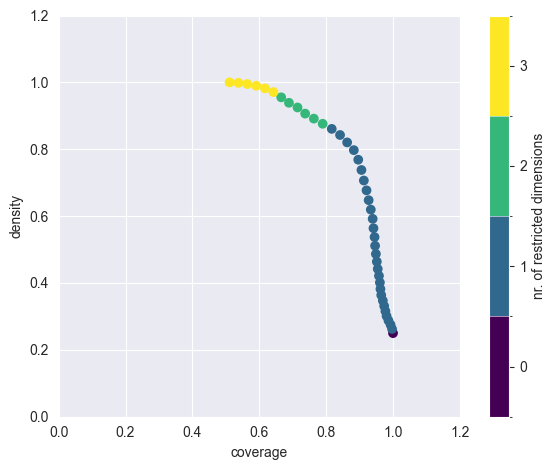

In [35]:
prim_alg = prim.Prim(x,
                     y_death_cost,
                     threshold=0.75,
                     peel_alpha=0.05,) # deze variabelen nog tweaken
box = prim_alg.find_box()

box.show_tradeoff()
plt.tight_layout()


coverage     0.5112
density      1.0000
id          40.0000
mass         0.1278
mean         1.0000
res_dim      3.0000
Name: 40, dtype: float64

             box 40                                 
                min       max      qp value qp value
A.3_pfail  0.000007  0.213261           NaN      0.0
A.1_pfail  0.323763  0.999914  4.551540e-67      NaN
A.2_pfail  0.098668  0.999941  1.407377e-12      NaN



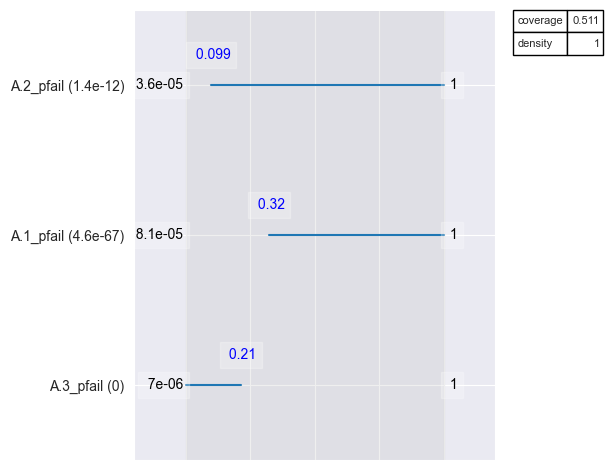

In [36]:
box.inspect()
box.inspect(style='graph')
plt.tight_layout()

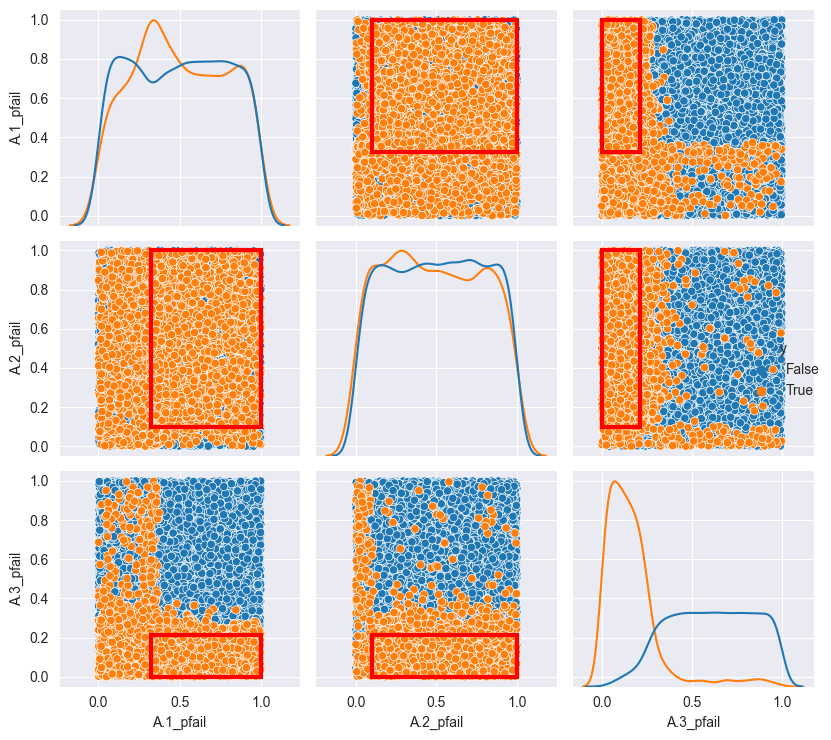

In [37]:
box.select(-1)
box.show_pairs_scatter()
fig = plt.gcf()
plt.tight_layout()


[MainProcess/INFO] 10000 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 0.9922027290448343, mass: 0.0513, coverage: 0.2036, density: 0.9922027290448343 restricted_dimensions: 4


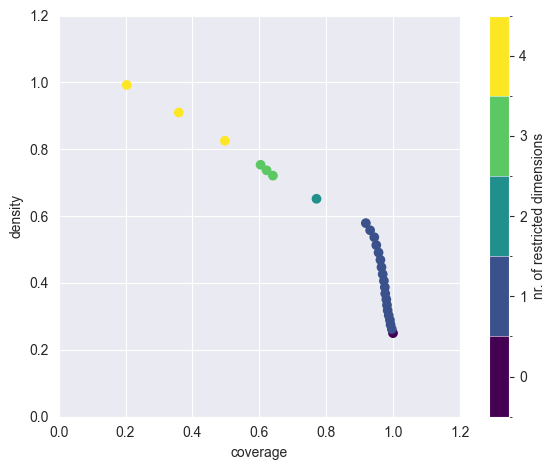

In [38]:
prim_alg = prim.Prim(x,
                     y_dama,
                     threshold=0.75,
                     peel_alpha=0.05,) # deze variabelen nog tweaken
box = prim_alg.find_box()

box.show_tradeoff()
plt.tight_layout()

coverage     0.203600
density      0.992203
id          25.000000
mass         0.051300
mean         0.992203
res_dim      4.000000
Name: 25, dtype: float64

                          box 25                                              
                             min              max      qp value       qp value
A.1_pfail               0.000081         0.358995           NaN  2.287536e-174
discount rate 1            {1.5}            {1.5}  3.730626e-56            NaN
discount rate 2  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}  7.752516e-12            NaN
discount rate 0  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}  3.147737e-08            NaN



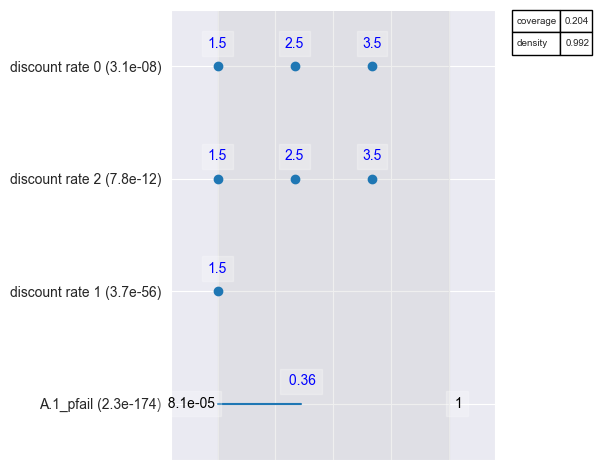

In [39]:
box.inspect()
box.inspect(style='graph')
plt.tight_layout()


D:\EPA\Advanced_simulation\EPA1361_Model-based_Decision-making\Lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


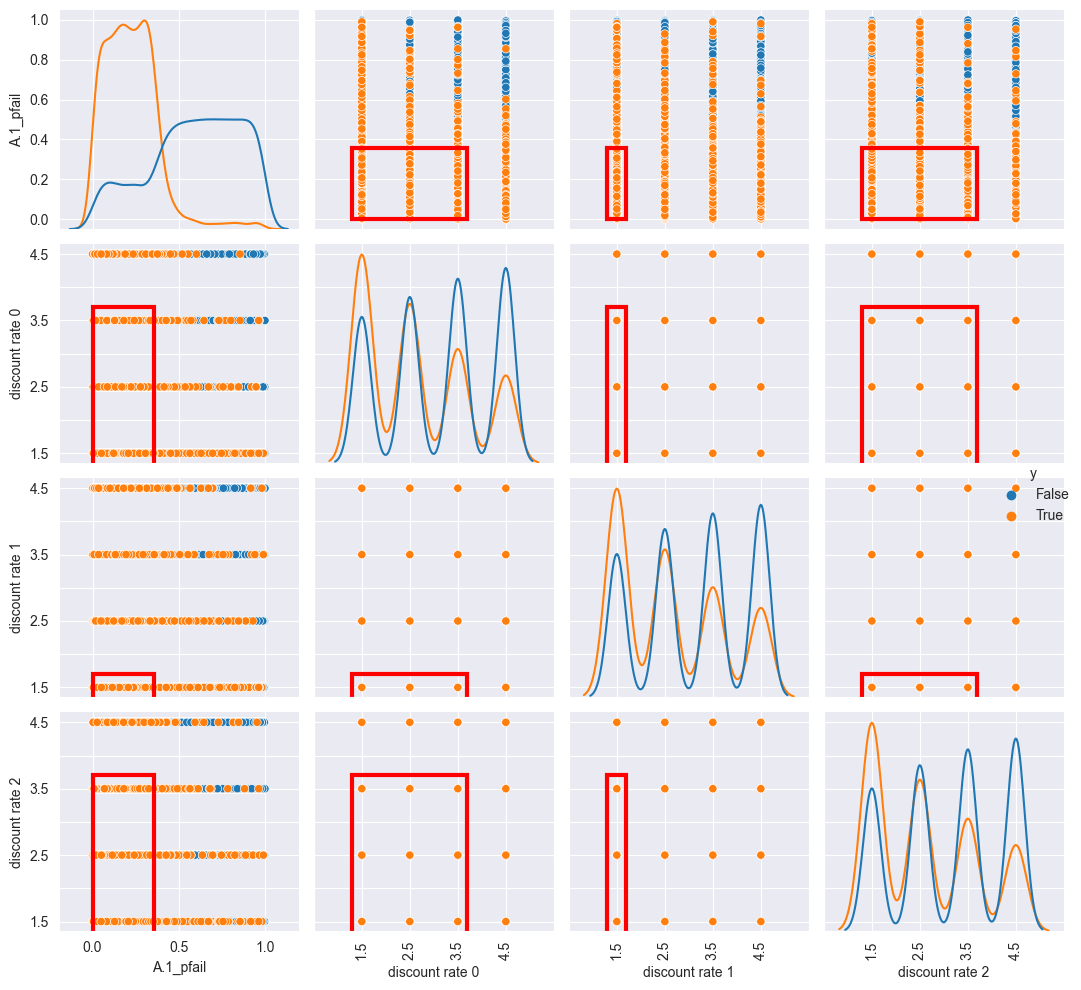

In [40]:
box.select(-1)
box.show_pairs_scatter()
fig = plt.gcf()
plt.tight_layout()


### CART

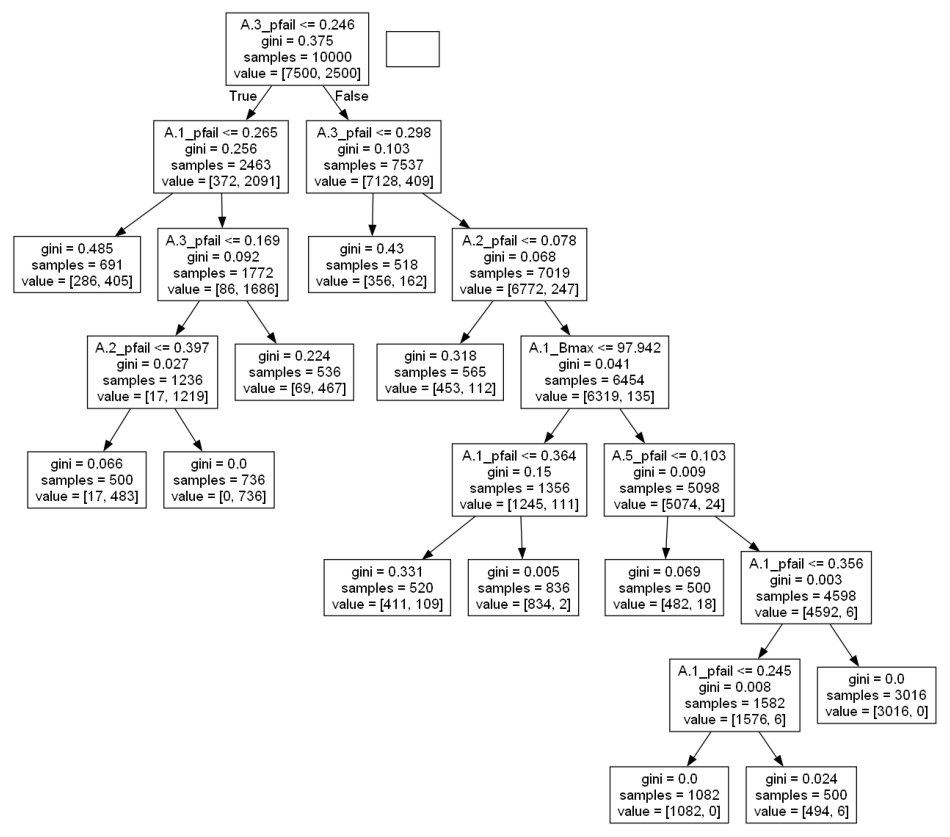

In [41]:
cart_plot = cart.CART(x, y_death_cost, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()

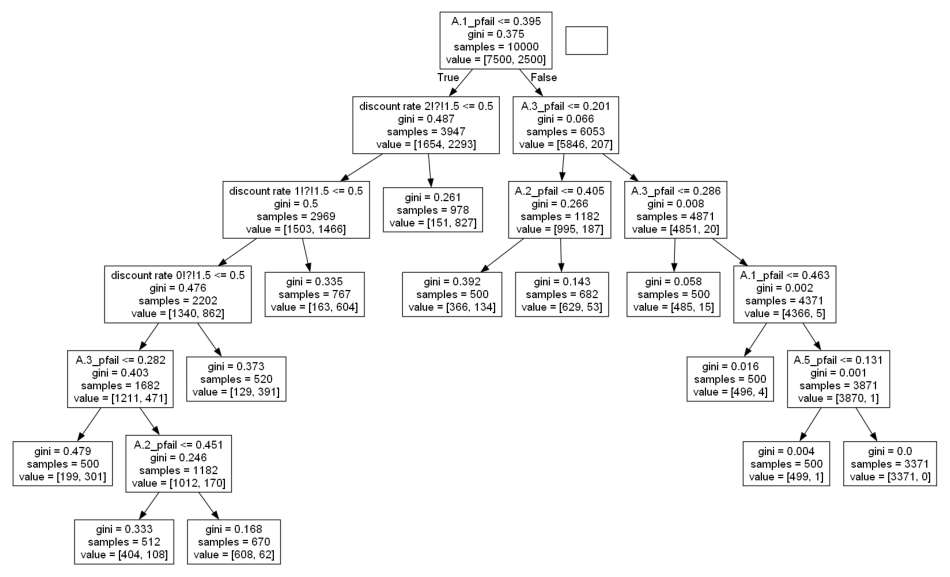

In [42]:
cart_plot = cart.CART(x, y_cost, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()